In [1]:
import time,csv
import numpy as np
from TDD.TDD import global_norm

In [2]:
from TDD.TDD import Ini_TDD
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num

def STDD_simulation(cir, Benchmark_Name=None, unique_table_reset=True, add_inputs_list=None, optimizer=None):
    n=get_real_qubit_num(cir)
    tn,indices=cir_2_tn(cir)
    Parameter_num=len(cir.parameters)
    #add y indices
    indices2=[]
    for i, item in enumerate(indices):
        indices2.append(item)
        if item[0]=='y':
            num=int(item.replace('y',''))
            # indices2.append('z%i'%num)
    t_start=time.time()
    #add sin cos indices

    '''
    TrDD process start
    '''
    sin_str=set()
    cos_str=set()
    for tensor in tn.tensors:
        for element in tensor.data.flatten(): 
            from sympy.core.expr import Expr 
            if isinstance(element,Expr):
                for symbol in element.free_symbols:
                    if '[' in str(element.free_symbols):
                        if '[' in str(symbol):
                            sin_str.add('sin('+str(symbol)+')')
                            cos_str.add('cos('+str(symbol)+')')
                    else:
                        sin_str.add('sin('+str(symbol)+')')
                        cos_str.add('cos('+str(symbol)+')')
    def get_numbers(s):
        import re
        # 使用正則表達式找到所有匹配"\d+"的子串，即連續的一個或多個數字
        numbers = re.findall("\d+", s)
        return int(numbers[0])

    sin_str=list(sin_str)
    sin_str.sort(key=get_numbers)
    cos_str=list(cos_str)
    cos_str.sort(key=get_numbers)
    sym_str=[]
    for i in range(len(sin_str)):
        sym_str.append(sin_str[i])
        sym_str.append(cos_str[i])
    # TDD process
    Ini_TDD(indices2,sym_str,type='TrDD',unique_table_reset=unique_table_reset)

    '''
    TrDD process end
    '''

    '''
    EXP process start 
    '''
    # from sympy import Symbol
    # parameters_dict=dict((Symbol(v.name.replace("[","").replace("]","")),k) for k, v in dict(enumerate(cir.parameters)).items())
    # Ini_TDD(indices2,type='Exp',var=parameters_dict,unique_table_reset=unique_table_reset)
    '''
    EXP process end 
    '''

    if add_inputs_list:
        from TDD.TDD_Q import add_inputs
        # add_inputs(tn,[0]*n,n)
        add_inputs(tn,add_inputs_list)

    start_cont=time.time()-t_start
    print('start cont ',start_cont)
    tdd, Max_node_num=tn.cont(optimizer=optimizer,max_node=True)
    cont_time=time.time()-start_cont-t_start
    print('cont complete',cont_time)

    from TDD.TDD import get_unique_table_num as gu1
    from TDD.TrDD.BDD import get_unique_table_num as gu2
    output_dict={'Benchmark Name':Benchmark_Name,
            'Parameter num': Parameter_num,
            'Qubit num.':tn.qubits_num,
            'Gate num.':len(cir.data),
            'Time':cont_time,
            'Node num. max':Max_node_num,
            'Node num. final':tdd.node_number(),
            'gu1':gu1(),
            'gu2':gu2()
    }
    return tdd, output_dict

In [3]:
def STDD_verify(cir, cir2, Benchmark_Name=None, unique_table_reset=True, add_inputs_list=None, optimizer=None):
    n=get_real_qubit_num(cir)
    tn, indices = cir_2_tn(cir.compose(cir2.inverse()))
    Parameter_num=len(cir.parameters)
    t_start=time.time()

    '''
    TrDD process start
    '''
    #add sin cos indices
    sin_str=set()
    cos_str=set()
    for tensor in tn.tensors:
        for element in tensor.data.flatten(): 
            from sympy.core.expr import Expr 
            if isinstance(element,Expr):
                for symbol in element.free_symbols:
                    if '[' in str(element.free_symbols):
                        if '[' in str(symbol):
                            sin_str.add('sin('+str(symbol)+')')
                            cos_str.add('cos('+str(symbol)+')')
                    else:
                        sin_str.add('sin('+str(symbol)+')')
                        cos_str.add('cos('+str(symbol)+')')
    def get_numbers(s):
        import re
        # 使用正則表達式找到所有匹配"\d+"的子串，即連續的一個或多個數字
        numbers = re.findall("\d+", s)
        return int(numbers[0])

    sin_str=list(sin_str)
    sin_str.sort(key=get_numbers)
    cos_str=list(cos_str)
    cos_str.sort(key=get_numbers)
    sym_str=[]
    for i in range(len(sin_str)):
        sym_str.append(sin_str[i])
        sym_str.append(cos_str[i])

    # TDD process
    Ini_TDD(indices,sym_str,type='TrDD',unique_table_reset=unique_table_reset)

    '''
    TrDD process end
    '''

    '''
    EXP process start 
    '''
    # from sympy import Symbol
    # parameters_dict=dict((Symbol(v.name.replace("[","").replace("]","")),k) for k, v in dict(enumerate(cir.parameters)).items())
    # Ini_TDD(indices,type='Exp',var=parameters_dict,unique_table_reset=unique_table_reset)
    '''
    EXP process end 
    '''

    if add_inputs_list:
        from TDD.TDD_Q import add_inputs
        # add_inputs(tn,[0]*n,n)
        add_inputs(tn,add_inputs_list)

    def cont2(tn,l1):
        from TDD.TDD import cont, get_identity_tdd
        max_node_num=0
        tdd=get_identity_tdd()
        l2=len(tn.tensors)-l1
        l=min(l1,l2)
        d=l1-l2
        r=int(l1/l2) if d>0 else int(l2/l1)
        if r == 1:
            for i in range(l):
                tdd1=tn.tensors[-(i+1)+l1].tdd()
                tdd=cont(tdd1,tdd)
                max_node_num=max(max_node_num,tdd.node_number())
                tdd2=tn.tensors[i+l1].tdd()
                tdd=cont(tdd,tdd2)
                max_node_num=max(max_node_num,tdd.node_number())
            if d>0:
                for i in range(d):
                    tdd1=tn.tensors[-(i+l+1)+l1].tdd()
                    tdd=cont(tdd1,tdd)
                    max_node_num=max(max_node_num,tdd.node_number())
            elif d<0:
                for i in range(abs(d)):
                    tdd2=tn.tensors[i+l+l1].tdd()
                    tdd=cont(tdd,tdd2)
                    max_node_num=max(max_node_num,tdd.node_number())
        elif d>0:
            for i in range(l2):
                for j in range(r):
                    tdd1=tn.tensors[-(r*i+j+1)+l1].tdd()
                    tdd=cont(tdd1,tdd)
                    max_node_num=max(max_node_num,tdd.node_number())
                tdd2=tn.tensors[i+l1].tdd()
                tdd=cont(tdd,tdd2)
                max_node_num=max(max_node_num,tdd.node_number())
            d2=l1-r*l2
            if d2 !=0:
                for i in range (d2):
                    tdd1=tn.tensors[-(i+r*l2+1)+l1].tdd()
                    tdd=cont(tdd1,tdd)
                    max_node_num=max(max_node_num,tdd.node_number())
        elif d<0:
            for i in range(l1):
                tdd1=tn.tensors[-(i+1)+l1].tdd()
                tdd=cont(tdd1,tdd)
                max_node_num=max(max_node_num,tdd.node_number())
                for j in range(r):
                    tdd2=tn.tensors[r*i+j+l1].tdd()
                    tdd=cont(tdd,tdd2)
                    max_node_num=max(max_node_num,tdd.node_number())
            d2=l2-r*l1
            if d2 !=0:
                for i in range(d2):
                    tdd2=tn.tensors[i+(r+1)*l1].tdd()
                    tdd=cont(tdd,tdd2)
                    max_node_num=max(max_node_num,tdd.node_number())
        return tdd, max_node_num

    l1=len(cir.data)

    start_cont=time.time()-t_start
    print('start cont ',start_cont)
    tdd, Max_node_num= cont2(tn,l1)
    cont_time=time.time()-start_cont-t_start
    print('cont complete',cont_time)

    from TDD.TDD import get_unique_table_num as gu1
    from TDD.TrDD.BDD import get_unique_table_num as gu2
    output_dict={'Benchmark Name':Benchmark_Name,
            'Parameter num': Parameter_num,
            'Qubit num.':tn.qubits_num,
            'Gate num.':len(cir.data),
            'Time':cont_time,
            'Node num. max':Max_node_num,
            'Node num. final':tdd.node_number(),
            'gu1':gu1(),
            'gu2':gu2()
    }
    return tdd, output_dict

In [4]:
def verify(tdd1,tdd2):
    start_time= time.time()
    # equivalent without global_norm
    if tdd1==tdd2:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"equivalent"}
        print(output_dict)
        return output_dict
    elif tdd1.node==tdd2.node:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"equivalent_up_to_global_phase"}
        print(output_dict)
        return output_dict
    tddn=global_norm(tdd1)
    tddn2=global_norm(tdd2)
    # equivalent with global_norm
    if tddn==tddn2:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"equivalent"}
        print('global_norm',output_dict)
        return output_dict
    elif tddn.node==tdd2.node:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"equivalent_up_to_global_phase"}
        print('global_norm',output_dict)
        return output_dict
    # not equivalent 
    else:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"not_equivalent"}
        print(output_dict)
        return output_dict

In [5]:
from qiskit import transpile
from qiskit.circuit import Parameter, QuantumCircuit, library

def circuit_generator(qubit_num=1,reps=1,function_name='TwoLocal'
                    ,basis_gates1=['id', 'rz', 'sx', 'x', 'cx']
                    ,basis_gates2=['rx','ry','h','cx']):

    if function_name=='TwoLocal':
        cir = library.TwoLocal(qubit_num, ['ry'],'cx', entanglement='circular', reps=reps)
    if function_name=='ExcitationPreserving':
        cir = library.ExcitationPreserving(qubit_num, mode='fsim', entanglement='full', reps=reps)
    if function_name=='RealAmplitudes':
        cir = library.RealAmplitudes(qubit_num, entanglement='full', reps=reps)
    if function_name=='EfficientSU2':
        cir = library.EfficientSU2(qubit_num, ['rx','h'], entanglement='circular', reps=reps)

    cir1=transpile(cir,basis_gates=basis_gates1)
    cir2=transpile(cir,basis_gates=basis_gates2)

    return cir1,cir2,'%s_%i_%i'%(function_name,qubit_num,reps)

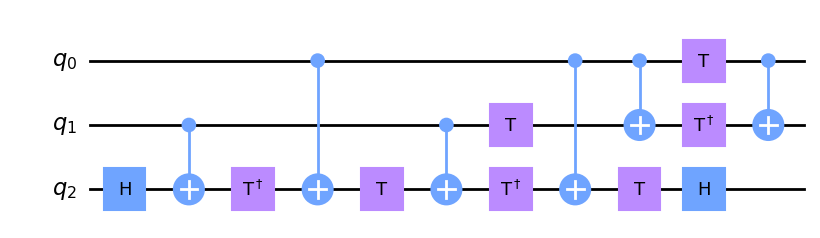

In [6]:
cir3=QuantumCircuit(3)
cir3.ccx(0,1,2)
cir3=transpile(cir3,basis_gates=['h', 't', 'tdg', 'cx'])
cir3.draw('mpl')

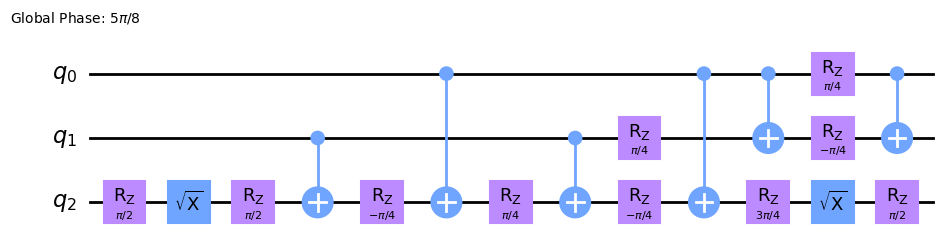

In [7]:
cir4=transpile(cir3,basis_gates=['id', 'rz', 'sx', 'x', 'cx'])
cir4.draw('mpl')

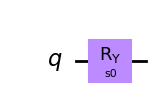

In [8]:
s0=Parameter('s%i'%0)
simple=QuantumCircuit(1)
# simple.rz(s0,0)

# simple.rz(-s0,0)

# simple.rx(s0,0)

simple.ry(s0,0)


simple.draw('mpl')

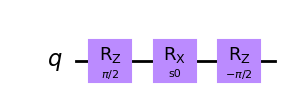

In [9]:
simple2=QuantumCircuit(1)

# simple2.rx(np.pi/2,0)
# simple2.ry(s0,0)
# simple2.rx(-np.pi/2,0)

# simple2.ry(np.pi/2,0)
# simple2.rx(s0,0)
# simple2.ry(-np.pi/2,0)

# simple2.ry(np.pi/2,0)
# simple2.rz(s0,0)
# simple2.ry(-np.pi/2,0)

simple2.rz(np.pi/2,0)
simple2.rx(s0,0)
simple2.rz(-np.pi/2,0)
simple2.draw('mpl')

In [10]:
def experiment(qubit_num=2,reps=1,function='RealAmplitudes', optimizer=None, file_name=None):
        cir1,cir2,circuit_nam=circuit_generator(qubit_num=qubit_num,reps=reps,function_name=function)
        tdd1,output_dict1=STDD_simulation(cir1, unique_table_reset=True, optimizer=optimizer)
        tdd2,output_dict2=STDD_simulation(cir2, unique_table_reset=False, optimizer=optimizer)
        output_dict3=verify(tdd1,tdd2)
        if file_name:
                with open(file_name, 'a', newline='') as csvfile:
                        fieldnames = ['Benchmark Name','Parameter num.','Qubit num.'
                                ,'Gate num._1','Time_1','Node num. max_1','Node num. final_1','gu1_1','gu2_1'
                                ,'Gate num._2','Time_2','Node num. max_2','Node num. final_2','gu1_2','gu2_2'
                                ,'Check_time','Totol_time','Equivalent']
                        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                        writer.writerow({'Benchmark Name':circuit_nam,'Parameter num.':output_dict1['Parameter num'],'Qubit num.':output_dict1['Qubit num.']
                        ,'Gate num._1':output_dict1['Gate num.'],'Time_1':output_dict1['Time'],'Node num. max_1':output_dict1['Node num. max']
                        ,'Node num. final_1':output_dict1['Node num. final'],'gu1_1':output_dict1['gu1'],'gu2_1':output_dict1['gu2']
                        ,'Gate num._2':output_dict2['Gate num.'],'Time_2':output_dict2['Time'],'Node num. max_2':output_dict2['Node num. max']
                        ,'Node num. final_2':output_dict2['Node num. final'],'gu1_2':output_dict2['gu1'],'gu2_2':output_dict2['gu2']
                        ,'Check_time':output_dict3['check_time'],'Totol_time':output_dict1['Time']+output_dict2['Time']+output_dict3['check_time']
                        ,'Equivalent':output_dict3['equivalence']})
        return {'Benchmark Name':circuit_nam,'Parameter num.':output_dict1['Parameter num'],'Qubit num.':output_dict1['Qubit num.']
                ,'Gate num._1':output_dict1['Gate num.'],'Time_1':output_dict1['Time'],'Node num. max_1':output_dict1['Node num. max']
                ,'Node num. final_1':output_dict1['Node num. final'],'gu1_1':output_dict1['gu1'],'gu2_1':output_dict1['gu2']
                ,'Gate num._2':output_dict2['Gate num.'],'Time_2':output_dict2['Time'],'Node num. max_2':output_dict2['Node num. max']
                ,'Node num. final_2':output_dict2['Node num. final'],'gu1_2':output_dict2['gu1'],'gu2_2':output_dict2['gu2']
                ,'Check_time':output_dict3['check_time'],'Totol_time':output_dict1['Time']+output_dict2['Time']+output_dict3['check_time']
                ,'Equivalent':output_dict3['equivalence']}



In [11]:
tdd1, output_dict=STDD_simulation(simple)
tdd2, output_dict=STDD_simulation(simple2,unique_table_reset=False)

verify(tdd1,tdd2)

['sin(s0)', 'cos(s0)']
start cont  0.015491485595703125
cont complete 0.0012226104736328125
['sin(s0)', 'cos(s0)']
start cont  0.00029349327087402344
cont complete 0.003206014633178711
{'check_time': 3.814697265625e-06, 'equivalence': 'equivalent'}


{'check_time': 3.814697265625e-06, 'equivalence': 'equivalent'}

In [12]:
from TDD.TDD import get_count
get_count()

add: 0 / 2 / 0.0
cont: 0 / 6 / 0.0


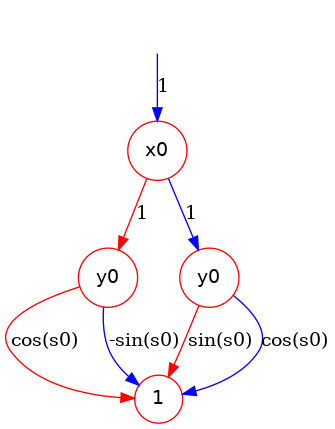

In [13]:
tdd1.show()

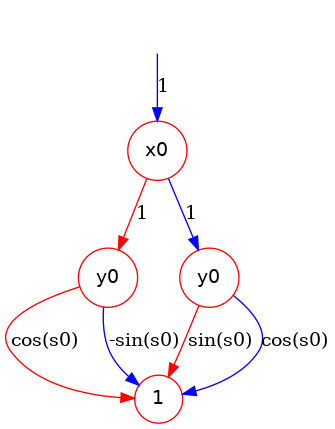

In [14]:
tdd2.show()

In [15]:
tdd, output_dict=STDD_verify(simple, simple2)
output_dict

start cont  0.0005993843078613281
cont complete 0.0047740936279296875


{'Benchmark Name': None,
 'Parameter num': 1,
 'Qubit num.': 1,
 'Gate num.': 1,
 'Time': 0.0047740936279296875,
 'Node num. max': 4,
 'Node num. final': 4,
 'gu1': 16,
 'gu2': 6}

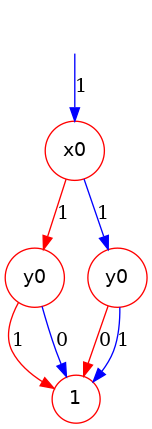

In [16]:
tdd.show()

In [17]:
experiment(qubit_num=3,reps=3,function='EfficientSU2')

['sin(θ[0])', 'cos(θ[0])', 'sin(θ[1])', 'cos(θ[1])', 'sin(θ[2])', 'cos(θ[2])', 'sin(θ[3])', 'cos(θ[3])', 'sin(θ[4])', 'cos(θ[4])', 'sin(θ[5])', 'cos(θ[5])', 'sin(θ[6])', 'cos(θ[6])', 'sin(θ[7])', 'cos(θ[7])', 'sin(θ[8])', 'cos(θ[8])', 'sin(θ[9])', 'cos(θ[9])', 'sin(θ[10])', 'cos(θ[10])', 'sin(θ[11])', 'cos(θ[11])']
start cont  0.007204771041870117
cont complete 0.7724196910858154
['sin(θ[0])', 'cos(θ[0])', 'sin(θ[1])', 'cos(θ[1])', 'sin(θ[2])', 'cos(θ[2])', 'sin(θ[3])', 'cos(θ[3])', 'sin(θ[4])', 'cos(θ[4])', 'sin(θ[5])', 'cos(θ[5])', 'sin(θ[6])', 'cos(θ[6])', 'sin(θ[7])', 'cos(θ[7])', 'sin(θ[8])', 'cos(θ[8])', 'sin(θ[9])', 'cos(θ[9])', 'sin(θ[10])', 'cos(θ[10])', 'sin(θ[11])', 'cos(θ[11])']
start cont  0.009313583374023438
cont complete 1.8903043270111084
global_norm {'check_time': 0.05220651626586914, 'equivalence': 'equivalent_up_to_global_phase'}


{'Benchmark Name': 'EfficientSU2_3_3',
 'Parameter num.': 12,
 'Qubit num.': 3,
 'Gate num._1': 57,
 'Time_1': 0.7724196910858154,
 'Node num. max_1': 64,
 'Node num. final_1': 64,
 'gu1_1': 1581,
 'gu2_1': 3773,
 'Gate num._2': 33,
 'Time_2': 1.8903043270111084,
 'Node num. max_2': 64,
 'Node num. final_2': 64,
 'gu1_2': 2909,
 'gu2_2': 15535,
 'Check_time': 0.05220651626586914,
 'Totol_time': 2.714930534362793,
 'Equivalent': 'equivalent_up_to_global_phase'}

In [18]:
cir,cir2,data=circuit_generator(qubit_num=3,reps=3, function_name='EfficientSU2'
                                ,basis_gates1=['id', 'rz', 'sx', 'x', 'cx']
                                ,basis_gates2=['rx','ry','h','cx'])

In [19]:
cir.draw()

global phase: π
     ┌─────────┐┌────┐┌──────────────┐┌──────────┐┌───┐     ┌─────────┐»
q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(θ[0] + π) ├┤ Rz(-π/2) ├┤ X ├──■──┤ Rz(π/2) ├»
     ├─────────┤├────┤├──────────────┤├──────────┤└─┬─┘┌─┴─┐└─────────┘»
q_1: ┤ Rz(π/2) ├┤ √X ├┤ Rz(θ[1] + π) ├┤ Rz(-π/2) ├──┼──┤ X ├─────■─────»
     ├─────────┤├────┤├──────────────┤├──────────┤  │  └───┘   ┌─┴─┐   »
q_2: ┤ Rz(π/2) ├┤ √X ├┤ Rz(θ[2] + π) ├┤ Rz(-π/2) ├──■──────────┤ X ├───»
     └─────────┘└────┘└──────────────┘└──────────┘             └───┘   »
«        ┌────┐  ┌──────────────┐  ┌──────────┐              ┌───┐     »
«q_0: ───┤ √X ├──┤ Rz(θ[3] + π) ├──┤ Rz(-π/2) ├──────────────┤ X ├──■──»
«     ┌──┴────┴─┐└────┬────┬────┘┌─┴──────────┴─┐┌──────────┐└─┬─┘┌─┴─┐»
«q_1: ┤ Rz(π/2) ├─────┤ √X ├─────┤ Rz(θ[4] + π) ├┤ Rz(-π/2) ├──┼──┤ X ├»
«     ├─────────┤     ├────┤     ├──────────────┤├──────────┤  │  └───┘»
«q_2: ┤ Rz(π/2) ├─────┤ √X ├─────┤ Rz(θ[5] + π) ├┤ Rz(-π/2) ├──■───────»
«     └─────────┘     └────┘     └──────────────┘└──────────┘          »
«     ┌─────────┐   ┌────┐  ┌──────────────┐  ┌──────────┐              ┌───┐»
«q_0: ┤ Rz(π/2) ├───┤ √X ├──┤ Rz(θ[6] + π) ├──┤ Rz(-π/2) ├──────────────┤ X ├»
«     └─────────┘┌──┴────┴─┐└────┬────┬────┘┌─┴──────────┴─┐┌──────────┐└─┬─┘»
«q_1: ─────■─────┤ Rz(π/2) ├─────┤ √X ├─────┤ Rz(θ[7] + π) ├┤ Rz(-π/2) ├──┼──»
«        ┌─┴─┐   ├─────────┤     ├────┤     ├──────────────┤├──────────┤  │  »
«q_2: ───┤ X ├───┤ Rz(π/2) ├─────┤ √X ├─────┤ Rz(θ[8] + π) ├┤ Rz(-π/2) ├──■──»
«        └───┘   └─────────┘     └────┘     └──────────────┘└──────────┘     »
«          ┌─────────┐   ┌────┐  ┌──────────────┐   ┌──────────┐              
«q_0: ──■──┤ Rz(π/2) ├───┤ √X ├──┤ Rz(θ[9] + π) ├───┤ Rz(-π/2) ├──────────────
«     ┌─┴─┐└─────────┘┌──┴────┴─┐└────┬────┬────┘┌──┴──────────┴─┐┌──────────┐
«q_1: ┤ X ├─────■─────┤ Rz(π/2) ├─────┤ √X ├─────┤ Rz(θ[10] + π) ├┤ Rz(-π/2) ├
«     └───┘   ┌─┴─┐   ├─────────┤     ├────┤     ├───────────────┤├──────────┤
«q_2: ────────┤ X ├───┤ Rz(π/2) ├─────┤ √X ├─────┤ Rz(θ[11] + π) ├┤ Rz(-π/2) ├
«             └───┘   └─────────┘     └────┘     └───────────────┘└──────────┘

In [20]:
tdd1, output_dict=STDD_simulation(cir)
get_count()

['sin(θ[0])', 'cos(θ[0])', 'sin(θ[1])', 'cos(θ[1])', 'sin(θ[2])', 'cos(θ[2])', 'sin(θ[3])', 'cos(θ[3])', 'sin(θ[4])', 'cos(θ[4])', 'sin(θ[5])', 'cos(θ[5])', 'sin(θ[6])', 'cos(θ[6])', 'sin(θ[7])', 'cos(θ[7])', 'sin(θ[8])', 'cos(θ[8])', 'sin(θ[9])', 'cos(θ[9])', 'sin(θ[10])', 'cos(θ[10])', 'sin(θ[11])', 'cos(θ[11])']
start cont  0.04818916320800781
cont complete 0.6104447841644287
add: 76 / 760 / 0.1
cont: 218 / 1576 / 0.1383248730964467


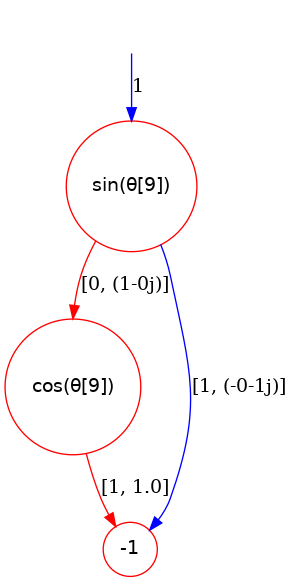

In [21]:
weight=tdd1.node.successor[0].out_weight[0]
weight.show()

In [22]:
# cir.draw()

In [23]:
# cir2.draw()

In [24]:
tdd, output_dict=STDD_verify(cir, cir2)
output_dict

start cont  0.03208327293395996
cont complete 0.26055264472961426


{'Benchmark Name': None,
 'Parameter num': 12,
 'Qubit num.': 3,
 'Gate num.': 57,
 'Time': 0.26055264472961426,
 'Node num. max': 34,
 'Node num. final': 10,
 'gu1': 1002,
 'gu2': 331}

In [25]:
tdd, output_dict=STDD_verify(simple, simple2)
output_dict

start cont  0.004282236099243164
cont complete 0.00529789924621582


{'Benchmark Name': None,
 'Parameter num': 1,
 'Qubit num.': 1,
 'Gate num.': 1,
 'Time': 0.00529789924621582,
 'Node num. max': 4,
 'Node num. final': 4,
 'gu1': 16,
 'gu2': 6}

In [26]:
a=tdd.show()

In [27]:
from mqt import qcec

qcec.verify(cir, cir2)

{
  "check_time": 0.000659604,
  "equivalence": "equivalent_up_to_global_phase",
  "parameterized": {
    "performed_instantiations": 0
  },
  "preprocessing_time": 0.000387102
}

In [28]:
qcec.verify(simple, simple2
            # , additional_instantiations=10
            )

{
  "check_time": 0.01144636,
  "equivalence": "not_equivalent",
  "parameterized": {
    "performed_instantiations": 2
  },
  "preprocessing_time": 0.001256107,
  "simulations": {
    "performed": 0,
    "started": 4
  }
}

In [29]:
# tdd.show()

# Compare

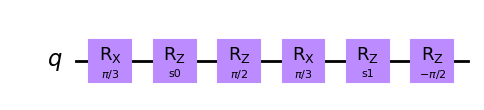

In [30]:
s0=Parameter('s%i'%0)
s1=Parameter('s%i'%1)
test=QuantumCircuit(1)
test.rx(np.pi/3,0)
test.rz(s0,0)
test.rz(np.pi/2,0)
test.rx(np.pi/3,0)
test.rz(s1,0)
test.rz(-np.pi/2,0)

test.draw('mpl')

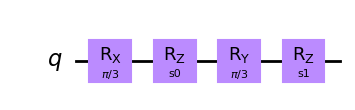

In [31]:
test2=QuantumCircuit(1)
test2.rx(np.pi/3,0)
test2.rz(s0,0)
test2.ry(np.pi/3,0)
test2.rz(s1,0)

test2.draw('mpl')

In [32]:
tdd, output_dict=STDD_verify(test, test2)
output_dict

start cont  0.0009477138519287109
cont complete 0.010963201522827148


{'Benchmark Name': None,
 'Parameter num': 2,
 'Qubit num.': 1,
 'Gate num.': 6,
 'Time': 0.010963201522827148,
 'Node num. max': 4,
 'Node num. final': 4,
 'gu1': 25,
 'gu2': 17}

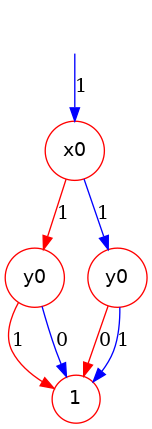

In [33]:
tdd.show()

In [34]:
qcec.verify(test, test2)

{
  "check_time": 0.004032721,
  "equivalence": "not_equivalent",
  "parameterized": {
    "performed_instantiations": 1
  },
  "preprocessing_time": 0.000807105,
  "simulations": {
    "performed": 0,
    "started": 2
  }
}

In [35]:
import sympy

x = sympy.Symbol('x')
y = sympy.Symbol('y')
epi=1e-10
expr = (1e-15 + 2j)*x + (3 + 4j)*x*y

new_expr=0
for term in expr.args:
    # print(term)
    free_symbols=term.free_symbols
    for i in range(len(free_symbols)):
        if i==0:
            coeff = term.coeff(free_symbols.pop())
        else:
            coeff = coeff.coeff(free_symbols.pop())
    if abs(coeff)-abs(coeff.as_real_imag()[0]) < epi:
        coeff=coeff.as_real_imag()[0]
    elif abs(coeff)-abs(coeff.as_real_imag()[1]) < epi:
        coeff=coeff.as_real_imag()[1] * sympy.I
    symbols = term.free_symbols
    terms=1 
    for symbol in symbols:
        terms*=symbol
    # print('term',coeff*terms)
    new_expr+=coeff*terms
print('solution',new_expr)


solution x*y*(3.0 + 4.0*I) + 2.0*I*x


In [36]:

class Tensor:
    def __init__(self,data=[],index=[],name=None,qubits=None):
        self.data=data
        self.index_set=index
        self.name=name
        self.qubits=qubits #This is used only when it represent a quantum gate 
        self._tdd=None
    @property
    def tdd(self):
        return self._tdd
    @tdd.setter
    def tdd(self):
        from TDD.TDD import get_tdd
        return get_tdd(self.data,self.index_set)  

In [37]:
# function_list=['RealAmplitudes','EfficientSU2']
# experiment_setup=[(5,3)]
    
# for qubit_num,reps in experiment_setup:
#     for function in function_list:
#             experiment(qubit_num=qubit_num, reps=reps, function=function, optimizer=None, file_name='STDD benchmark.csv')
        

In [38]:

# with open('STDD cir_partition2 benchmark.csv', 'w', newline='') as csvfile:
#     fieldnames=['Benchmark Name','Parameter num.','Qubit num.'
# ,'Gate num._1','Time_1','Node num. max_1','Node num. final_1','gu1_1','gu2_1'
# ,'Gate num._2','Time_2','Node num. max_2','Node num. final_2','gu1_2','gu2_2'
# ,'Check_time','Totol_time','Equivalent']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()
